In [123]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [3]:
np.random.seed(42)

def generate_traffic_data(num_intervals, max_vehicles_per_lane):
    traffic_data = {
        'time_interval' : list(range(num_intervals)),
        'north_south_lane_1' : np.random.randint(0, max_vehicles_per_lane, num_intervals),
        'north_south_lane_2' : np.random.randint(0, max_vehicles_per_lane, num_intervals),
        'east_west_lane_1' : np.random.randint(0, max_vehicles_per_lane, num_intervals),
        'east_west_lane_2' : np.random.randint(0, max_vehicles_per_lane, num_intervals)
    }
    return pd.DataFrame(traffic_data)

num_intervals = 24
max_vehicles_per_lane = 20

traffic_data = generate_traffic_data(num_intervals, max_vehicles_per_lane)
traffic_data

,time_interval,north_south_lane_1,north_south_lane_2,east_west_lane_1,east_west_lane_2
0,0,6,18,3,8
1,1,19,11,17,14
2,2,14,19,7,12
3,3,10,2,3,0
4,4,7,4,1,6
5,5,6,18,5,8
6,6,18,6,9,0
7,7,10,8,3,11
8,8,10,6,17,7
9,9,3,17,11,10


In [256]:
def simulate_traffic(traffic_data, chromosome ):
    north_south_green_duration = chromosome['north_south_green_duration']
    east_west_green_duration = chromosome['east_west_green_duration']
    
    north_south_traffic = traffic_data[['north_south_lane_1', 'north_south_lane_2']].mean(axis = 1)
    east_west_traffic = traffic_data[['east_west_lane_1', 'east_west_lane_2']].mean(axis = 1)
    
    north_south_wait_time = np.sum(np.maximum(0, east_west_green_duration - north_south_green_duration) + north_south_traffic - max(0, north_south_green_duration))
    east_west_wait_time = np.sum(np.maximum(0, north_south_green_duration - east_west_green_duration) + east_west_traffic - max(0, east_west_green_duration))
    
    fitness = 1 / (1 + north_south_wait_time + east_west_wait_time)
    
    return fitness

In [257]:
def initialize_population(population_size):
    population = []
    for i in range(population_size):
        chromosome = {
            'north_south_green_duration' : random.randint(10,60),
            'east_west_green_duration': random.randint(10,60)
        }
        population.append(chromosome)
    return population

In [258]:
initialize_population(10)

[{'north_south_green_duration': 19, 'east_west_green_duration': 57},
 {'north_south_green_duration': 38, 'east_west_green_duration': 37},
 {'north_south_green_duration': 33, 'east_west_green_duration': 17},
 {'north_south_green_duration': 21, 'east_west_green_duration': 13},
 {'north_south_green_duration': 57, 'east_west_green_duration': 26},
 {'north_south_green_duration': 14, 'east_west_green_duration': 16},
 {'north_south_green_duration': 22, 'east_west_green_duration': 38},
 {'north_south_green_duration': 14, 'east_west_green_duration': 32},
 {'north_south_green_duration': 36, 'east_west_green_duration': 19},
 {'north_south_green_duration': 29, 'east_west_green_duration': 27}]

In [259]:
def crossover(parent1, parent2):
    crossover_point = random.randint(0,1)
    child = {
            'north_south_green_duration' : parent1['north_south_green_duration'] if crossover_point == 0 else parent2['north_south_green_duration'],
             'east_west_green_duration' : parent2[ 'east_west_green_duration'] if crossover_point == 0 else parent1['east_west_green_duration']
    }
    return child

In [260]:
def mutation(chromosome, mutation_rate):
    if random.random() < mutation_rate:
        chromosome['north_south_green_duration'] = chromosome['north_south_green_duration'] + random.randint(-5,5)
        chromosome['east_west_green_duration'] = chromosome['east_west_green_duration'] + random.randint(-5,5)
        chromosome['north_south_green_duration'] = max(10, chromosome['north_south_green_duration'])
        chromosome['east_west_green_duration'] = max(10, chromosome['east_west_green_duration'])
    
    return chromosome

In [261]:
def genetic_algorithm(traffic_data, population_size, generations, mutation_rate):
    
    population = initialize_population(population_size)
    best_fitness_values = []
    for i in range(generations):
        fitness_scores = [simulate_traffic(traffic_data,chromosome) for chromosome in population]
        selected_indices = sorted(range(population_size), key=lambda x: fitness_scores[x], reverse = True)[:population_size // 2]
        selected_population = [population[j] for j in selected_indices]
        
        children = []
        for k in range(population_size // 2):
            parent1 = random.choice(selected_population)
            parent2 = random.choice(selected_population)
            child = crossover(parent1, parent2)
            child = mutation(child, mutation_rate)
            children.append(child)
            
        population = selected_population + children
              
        best_chromosome = max(population, key=lambda x: simulate_traffic(traffic_data, x))
        best_fitness = simulate_traffic(traffic_data, best_chromosome)
        best_fitness_values.append(best_fitness)
        
    best_chromosome = max(population, key=lambda x: simulate_traffic(traffic_data, x))
    return best_chromosome, best_fitness_values

In [262]:
population_size = 30
generations = 100
mutation_rate = 0.1
best_chromosome, best_fitness_values = genetic_algorithm(traffic_data, population_size, generations, mutation_rate)
print("Best Chromosome: ", best_chromosome)
print("Fitness: ", simulate_traffic(traffic_data, best_chromosome))

Best Chromosome:  {'north_south_green_duration': 99, 'east_west_green_duration': 98}
Fitness:  -0.0002346041055718475


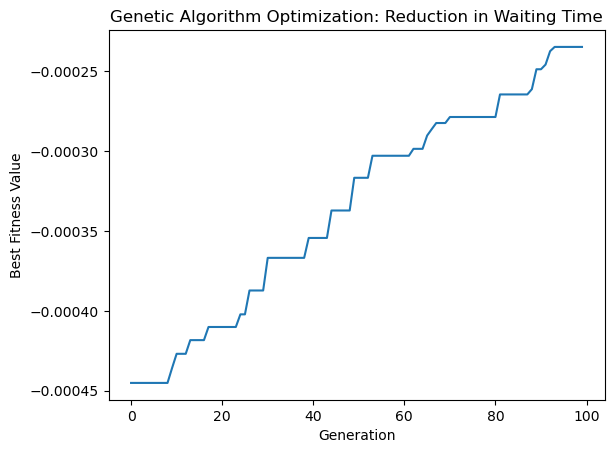

In [263]:
plt.plot(range(len(best_fitness_values)), best_fitness_values)
plt.xlabel('Generation')
plt.ylabel('Best Fitness Value')
plt.title('Genetic Algorithm Optimization: Reduction in Waiting Time')
plt.show()

In [255]:
north_south_green_duration = 10
east_west_green_duration = 10
    
north_south_traffic = traffic_data[['north_south_lane_1', 'north_south_lane_2']].mean(axis=1)
east_west_traffic = traffic_data[['east_west_lane_1', 'east_west_lane_2']].mean(axis=1)
    
north_south_wait_time = np.sum(north_south_traffic - max(0, north_south_green_duration)) + east_west_green_duration 
east_west_wait_time = np.sum(east_west_traffic - max(0, east_west_green_duration)) + north_south_green_duration
    
print("North-South Wait Time:", north_south_wait_time)
print("East-West Wait Time:", east_west_wait_time)
    
    # Avoid division by zero
if north_south_wait_time + east_west_wait_time == 0:
    fitness = float('inf')  # Positive infinity
else:
    fitness = 1 / (1 + north_south_wait_time + east_west_wait_time)
    
print("Fitness:", fitness)


North-South Wait Time: 6.5
East-West Wait Time: -26.0
Fitness: -0.05405405405405406
